**Accuracy upto 99 percent. Used argmax on prediction vector to catagorize results. Used T1ce Modality**

In [ ]:
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Activation, Reshape, Dense
from keras.layers.convolutional import Convolution2D
from keras.layers import BatchNormalization
#from keras import layers
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

In [ ]:
x_train = np.load('/content/drive/MyDrive/brain tumor segmentation/huzaifa data/Prepared_MRI_data/Origna_data_handling/Stack_Arrays/image_t1ce_combined.npy')
#x_test = np.load('/content/drive/MyDrive/brain tumor segmentation/huzaifa data/Prepared_MRI_data/Origna_data_handling/Stack_Arrays/val_images.npy')
y_train = np.load('/content/drive/MyDrive/brain tumor segmentation/huzaifa data/Prepared_MRI_data/Origna_data_handling/Stack_Arrays/mask_combined.npy')
#y_test = np.load('/content/drive/MyDrive/brain tumor segmentation/huzaifa data/Prepared_MRI_data/Origna_data_handling/Stack_Arrays/val_masks.npy')

<function matplotlib.pyplot.imshow>

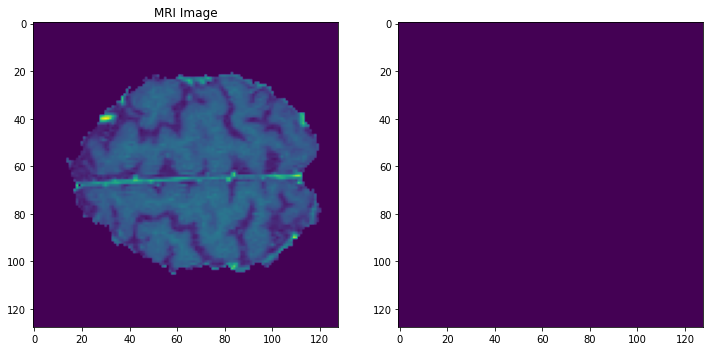

In [ ]:
rand=np.random.randint(0,127 )
rand_2=np.random.randint(0,127)
plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.title('MRI Image')
plt.imshow(x_train[rand,:,:,rand_2])
plt.subplot(122)
plt.imshow(y_train[rand,:,:,rand_2])
plt.imshow

In [ ]:
image2D = []
for i in range(210):
  for j in range(128):
    image2D.append(x_train[i,:,:,j])

x_train = np.array(image2D)

In [ ]:
mask2D = []
for i in range(210):
  for j in range(128):
    mask2D.append(y_train[i,:,:,j])
y_train = np.array(mask2D)

In [ ]:
image2D = 0
mask2D = 0

In [ ]:
import random

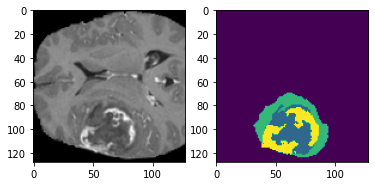

In [ ]:
#n = random.randint(45,95)
x = random.randint(0,10000)

plt.subplot(121)
plt.imshow(x_train[x,:,:], cmap = 'gray')
plt.subplot(122)
plt.imshow(y_train[x,:,:])


In [ ]:
#x_val.shape, y_val.shape, x_tr.shape, y_tr.shape

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.10, random_state = 101)

In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((24192, 128, 128), (2688, 128, 128), (24192, 128, 128), (2688, 128, 128))

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.20, random_state = 101)

In [ ]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((19353, 128, 128), (4839, 128, 128), (19353, 128, 128), (4839, 128, 128))

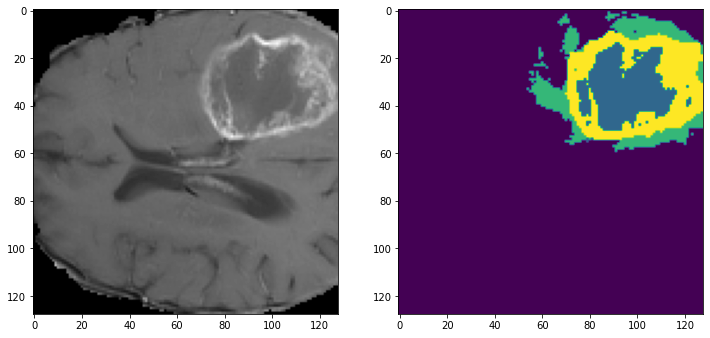

In [ ]:
x = random.randint(0,19353)
plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(x_train[x,:,:], cmap = 'gray')
plt.subplot(122)
plt.imshow(y_train[x,:,:])


In [ ]:
x_train = np.expand_dims(x_train, axis = 3)
x_val = np.expand_dims(x_val, axis = 3)
x_test = np.expand_dims(x_test, axis = 3)

In [ ]:
x_train.shape,x_val.shape,x_test.shape

((19353, 128, 128, 1), (4839, 128, 128, 1), (2688, 128, 128, 1))

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)
#y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
y_train.shape,y_val.shape,y_test.shape

((19353, 128, 128, 4), (4839, 128, 128, 4), (2688, 128, 128))

In [ ]:
def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def dice_coef(y_true, y_pred, smooth = 100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))


In [ ]:
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Activation, Reshape, Dense
from keras.layers.convolutional import Convolution2D
from keras.layers import BatchNormalization

#from layers import MaxPoolingWithArgmax2D, MaxUnpooling2D

def segnet(
        input_shape,
        n_labels,
        kernel=3,
        pool_size=(2, 2),
        output_mode="softmax"):
    # encoder
    inputs = Input(shape=input_shape)
    #inputs = tf.convert_to_tensor(inputs)
    conv_1 = Convolution2D(64, (kernel, kernel), padding="same", kernel_initializer='he_normal', name="block1_conv1")(inputs)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Activation("relu")(conv_1)
    conv_2 = Convolution2D(64, (kernel, kernel), padding="same", kernel_initializer='he_normal', name="block1_conv2")(conv_1)
    conv_2 = BatchNormalization()(conv_2)
    conv_2 = Activation("relu")(conv_2)
    pool_1 = MaxPooling2D(pool_size, name="block1_pool")(conv_2)

    conv_3 = Convolution2D(128, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block2_conv1")(pool_1)
    conv_3 = BatchNormalization()(conv_3)
    conv_3 = Activation("relu")(conv_3)
    conv_4 = Convolution2D(128, (kernel, kernel), padding="same", kernel_initializer='he_normal',  name="block2_conv2")(conv_3)
    conv_4 = BatchNormalization()(conv_4)
    conv_4 = Activation("relu")(conv_4)

    pool_2 = MaxPooling2D(pool_size, name="block2_pool")(conv_4)

    conv_5 = Convolution2D(256, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block3_conv1")(pool_2)
    conv_5 = BatchNormalization()(conv_5)
    conv_5 = Activation("relu")(conv_5)
    conv_6 = Convolution2D(256, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block3_conv2")(conv_5)
    conv_6 = BatchNormalization()(conv_6)
    conv_6 = Activation("relu")(conv_6)
    conv_7 = Convolution2D(256, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block3_conv3")(conv_6)
    conv_7 = BatchNormalization()(conv_7)
    conv_7 = Activation("relu")(conv_7)

    pool_3 = MaxPooling2D(pool_size, name="block3_pool")(conv_7)

    conv_8 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal', name="block4_conv1")(pool_3)
    conv_8 = BatchNormalization()(conv_8)
    conv_8 = Activation("relu")(conv_8)
    conv_9 = Convolution2D(512, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block4_conv2")(conv_8)
    conv_9 = BatchNormalization()(conv_9)
    conv_9 = Activation("relu")(conv_9)
    conv_10 = Convolution2D(512, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block4_conv3")(conv_9)
    conv_10 = BatchNormalization()(conv_10)
    conv_10 = Activation("relu")(conv_10)

    pool_4 = MaxPooling2D(pool_size, name="block4_pool")(conv_10)

    conv_11 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal', name="block5_conv1")(pool_4)
    conv_11 = BatchNormalization()(conv_11)
    conv_11 = Activation("relu")(conv_11)
    conv_12 = Convolution2D(512, (kernel, kernel), padding="same" , kernel_initializer='he_normal',  name="block5_conv2")(conv_11)
    conv_12 = BatchNormalization()(conv_12)
    conv_12 = Activation("relu")(conv_12)
    conv_13 = Convolution2D(512, (kernel, kernel), padding="same" , kernel_initializer='he_normal',  name="block5_conv3")(conv_12)
    conv_13 = BatchNormalization()(conv_13)
    conv_13 = Activation("relu")(conv_13)

    pool_5 = MaxPooling2D(pool_size, name="block5_pool")(conv_13)
   
    # decoder
    unpool_1 = UpSampling2D(pool_size)(pool_5)

    conv_14 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal')(unpool_1)
    conv_14 = BatchNormalization()(conv_14)
    conv_14 = Activation("relu")(conv_14)
    conv_15 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_14)
    conv_15 = BatchNormalization()(conv_15)
    conv_15 = Activation("relu")(conv_15)
    conv_16 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_15)
    conv_16 = BatchNormalization()(conv_16)
    conv_16 = Activation("relu")(conv_16)

    unpool_2 = UpSampling2D(pool_size)(conv_16)

    conv_17 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal')(unpool_2)
    conv_17 = BatchNormalization()(conv_17)
    conv_17 = Activation("relu")(conv_17)
    conv_18 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_17)
    conv_18 = BatchNormalization()(conv_18)
    conv_18 = Activation("relu")(conv_18)
    conv_19 = Convolution2D(256, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_18)
    conv_19 = BatchNormalization()(conv_19)
    conv_19 = Activation("relu")(conv_19)

    unpool_3 = UpSampling2D(pool_size)(conv_19)

    conv_20 = Convolution2D(256, (kernel, kernel), padding="same", kernel_initializer='he_normal')(unpool_3)
    conv_20 = BatchNormalization()(conv_20)
    conv_20 = Activation("relu")(conv_20)
    conv_21 = Convolution2D(256, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_20)
    conv_21 = BatchNormalization()(conv_21)
    conv_21 = Activation("relu")(conv_21)
    conv_22 = Convolution2D(128, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_21)
    conv_22 = BatchNormalization()(conv_22)
    conv_22 = Activation("relu")(conv_22)

    unpool_4 = UpSampling2D(pool_size)(conv_22)

    conv_23 = Convolution2D(128, (kernel, kernel), padding="same", kernel_initializer='he_normal')(unpool_4)
    conv_23 = BatchNormalization()(conv_23)
    conv_23 = Activation("relu")(conv_23)
    conv_24 = Convolution2D(64, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_23)
    conv_24 = BatchNormalization()(conv_24)
    conv_24 = Activation("relu")(conv_24)

    unpool_5 = UpSampling2D(pool_size)(conv_24)
    #pool, ind, output_shape, batch_size, name=None

    conv_25 = Convolution2D(64, (kernel, kernel), padding="same", kernel_initializer='he_normal')(unpool_5)
    conv_25 = BatchNormalization()(conv_25)
    conv_25 = Activation("relu")(conv_25)

    conv_26 = Convolution2D(n_labels, (1, 1), padding="same", kernel_initializer='he_normal')(conv_25)
    conv_26 = BatchNormalization()(conv_26)

    conv_26 = Reshape((128,128,4))(conv_26)
    #conv_26 = Dense(4)(conv_26)
    outputs = Activation(output_mode)(conv_26)
    print("Build decoder done..")
    #pred = Reshape((128,128,128))(outputs)
    model = Model(inputs=inputs, outputs=outputs, name="SegNet")

    return model


model = segnet(input_shape=(128,128,1), n_labels=4)

model.summary()
print(model.input_shape)
print(model.output_shape)

Build decoder done..
Model: "SegNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      640       
_________________________________________________________________
batch_normalization_130 (Bat (None, 128, 128, 64)      256       
_________________________________________________________________
activation_129 (Activation)  (None, 128, 128, 64)      0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_131 (Bat (None, 128, 128, 64)      256       
_________________________________________________________________
activation_130 (Activation)  (None, 128

In [ ]:

#model.summary()
model.compile(optimizer= Adam(learning_rate=0.0001), loss= ["categorical_crossentropy"]
                  , metrics=[iou, dice_coef, precision, recall, accuracy])

#hist = model.fit(x_train, y_train, epochs= 30, batch_size= 10, validation_data= (x_val, y_val), verbose=1)

In [ ]:
hist = model.fit(x_train, y_train, epochs= 30, batch_size= 8, validation_data= (x_val, y_val), verbose=1)

Epoch 1/30
2420/2420 [==============================] - 199s 74ms/step - loss: 1.0796 - iou: 0.9947 - dice_coef: 0.3712 - precision: 0.4286 - recall: 0.0055 - accuracy: 0.7501 - val_loss: 0.8742 - val_iou: 0.9958 - val_dice_coef: 0.4432 - val_precision: 0.4146 - val_recall: 0.0153 - val_accuracy: 0.7488
Epoch 2/30
2420/2420 [==============================] - 176s 73ms/step - loss: 0.7709 - iou: 0.9965 - dice_coef: 0.4933 - precision: 0.8370 - recall: 0.5154 - accuracy: 0.8762 - val_loss: 0.6245 - val_iou: 0.9973 - val_dice_coef: 0.5561 - val_precision: 0.9858 - val_recall: 0.9305 - val_accuracy: 0.9793
Epoch 3/30
2420/2420 [==============================] - 176s 73ms/step - loss: 0.5539 - iou: 0.9977 - dice_coef: 0.6031 - precision: 0.9833 - recall: 0.9336 - accuracy: 0.9794 - val_loss: 0.4517 - val_iou: 0.9983 - val_dice_coef: 0.6592 - val_precision: 0.9800 - val_recall: 0.9550 - val_accuracy: 0.9839
Epoch 4/30
2420/2420 [==============================] - 177s 73ms/step - loss: 0.3972

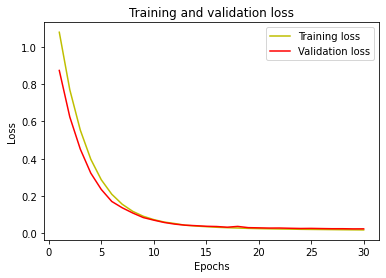

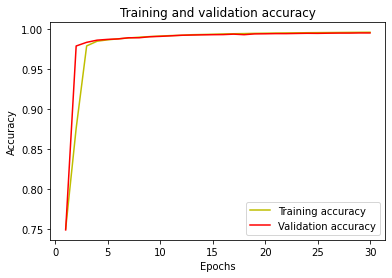

In [ ]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/brain tumor segmentation/huzaifa data/Models/Model20 improved/SegNet20_model.h5')

In [ ]:
prediction = model.predict(x_test)

In [ ]:
prediction.shape,x_test.shape

((2688, 128, 128, 4), (2688, 128, 128, 1))

In [ ]:
pred=np.argmax(prediction, axis=3)

In [ ]:
pred.shape

(2688, 128, 128)

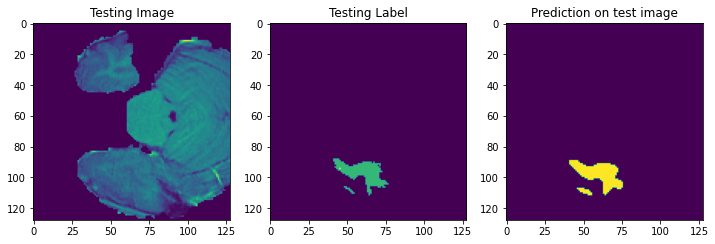

In [ ]:
#n=random.randint(45,95)


image = random.randint(0,2688)

plt.figure(figsize=(12, 8))
plt.subplot(131)
plt.title('Testing Image')
plt.imshow(x_test[image,:,:,0])
plt.subplot(132)
plt.title('Testing Label')
plt.imshow(y_test[image,:,:])
plt.subplot(133)
plt.title('Prediction on test image')
plt.imshow(pred[image,:,:])
plt.show()

In [ ]:
x = np.expand_dims(x_val, axis =3)

In [ ]:
x_val.shape, prediction.shape

((5376, 128, 128), (5376, 128, 128, 4))

In [ ]:
acc = accuracy(y_test, pred)
print(acc)

tf.Tensor(0.9913198, shape=(), dtype=float32)


In [ ]:
x_tst = np.expand_dims(x_train, axis = 3)

In [ ]:
y_tst = tf.keras.utils.to_categorical(y_test)

In [ ]:
pred = tf.keras.utils.to_categorical(prediction)

In [ ]:
x_test.shape, y_tst.shape

((2688, 128, 128, 1), (2688, 128, 128, 4))

In [ ]:

print('\n-------------On Training Set--------------------------\n')
res = model.evaluate(x_train, y_train, batch_size= 10)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')

print('\n-------------On validation Set---------------------\n')
res = model.evaluate(x_val, y_val, batch_size= 10)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')

print('\n-------------On Test Set---------------------\n')
res = model.evaluate(x_test, y_tst, batch_size= 10)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')


-------------On Training Set--------------------------

1936/1936 [==============================] - 55s 29ms/step - loss: 0.0168 - iou: 0.9999 - dice_coef: 0.9899 - precision: 0.9937 - recall: 0.9928 - accuracy: 0.9966
________________________
IOU:       |   99.99  |
Dice Coef: |   98.99  |
Precision: |   99.37  |
Recall:    |   99.28  |
Accuracy:  |   99.66  |
Loss:      |   1.68  |
________________________

-------------On validation Set---------------------

484/484 [==============================] - 14s 29ms/step - loss: 0.0229 - iou: 0.9999 - dice_coef: 0.9880 - precision: 0.9918 - recall: 0.9908 - accuracy: 0.9956
________________________
IOU:       |   99.99  |
Dice Coef: |   98.80  |
Precision: |   99.18  |
Recall:    |   99.08  |
Accuracy:  |   99.56  |
Loss:      |   2.29  |
________________________

-------------On Test Set---------------------

269/269 [==============================] - 8s 28ms/step - loss: 0.0223 - iou: 0.9999 - dice_coef: 0.9881 - precision: 0.9919 - re